In [1]:
import torch
import torch.nn as nn
from exp.nb_12 import test_close
torch.seed()

i_h = torch.nn.Embedding(1001, 50)
h_h = torch.nn.Linear(50, 50)
h_o = torch.nn.Linear(50, 1001)
relu = torch.nn.ReLU()

In [2]:
# continue refactor
x = torch.tensor([[1,2,3], [11,12,13], [111,112,113]]); print(x[:, 0]); print(x.shape[1])
input = i_h(x)
print('x.shape', x.shape)
h = 0
for i in range(x.shape[1]):
    h = relu(h_h(h + i_h(x[:, i])))
o3 = h_o(h)
o3.shape, h.shape

tensor([  1,  11, 111])
3
x.shape torch.Size([3, 3])


(torch.Size([3, 1001]), torch.Size([3, 50]))

In [3]:
print(h.shape)
h[0]

torch.Size([3, 50])


tensor([0.1321, 0.0000, 0.0000, 0.0000, 0.0000, 0.2844, 0.0000, 0.0327, 0.0000,
        0.6509, 0.3402, 0.2649, 0.0000, 0.0000, 0.2951, 0.4416, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0334, 0.0000, 0.0000, 0.0000, 0.0000, 0.7293, 0.0000,
        0.5065, 0.4021, 1.1643, 0.1924, 0.0335, 0.1732, 0.0976, 0.0000, 1.2522,
        0.0000, 0.3773, 1.5590, 0.1777, 0.3854, 0.0657, 0.1099, 0.0000, 0.9420,
        1.5679, 1.0433, 1.4135, 0.4119, 0.0000], grad_fn=<SelectBackward>)

In [4]:
test_close(i_h(x[:, 0]), input[:, 0, :])

In [5]:
rnn = nn.RNN(50, 50, 1, nonlinearity='relu', batch_first=True)
h0 = torch.zeros(1, 3, 50)
# assign initial value
rnn.weight_hh_l0.data = h_h.weight.data
rnn.bias_hh_l0.data = h_h.bias.data
rnn.weight_ih_l0.data = h_h.weight.data
rnn.bias_ih_l0.data = torch.zeros_like(rnn.bias_ih_l0)
test_close(rnn.weight_hh_l0, h_h.weight)

output, hn = rnn(input, h0)

output.shape, hn.shape

(torch.Size([3, 3, 50]), torch.Size([1, 3, 50]))

In [6]:
test_close(hn.squeeze(0), h)

In [7]:
# every thing look find now. We will replace our implement by torch.nn.RNN

In [8]:
from fastai.data.external import URLs, untar_data

In [9]:
import fastai

In [10]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

(#2) [Path('/home/vule/.fastai/data/human_numbers/train.txt'),Path('/home/vule/.fastai/data/human_numbers/valid.txt')]

In [11]:
from fastcore.foundation import L
import pandas as pd
from torch import tensor
from fastai.data.core import DataLoaders

# Load data
train_df = pd.read_csv(path/'train.txt', header=None, names=['number'])
valid_df = pd.read_csv(path/'valid.txt', header=None, names=['number'])
data_df = pd.concat([train_df, valid_df])
data_df.number = data_df.number.apply(lambda x: x.strip())


# Convert word to number.
text = ' . '.join(data_df.number.to_list())
tokens = text.split(' ')
vocabs = L(tokens).unique()
word2idx = {w:i for i, w in enumerate(vocabs)}
nums = [word2idx[w] for w in tokens]

In [12]:
len(vocabs)

30

In [13]:
# L([(tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3)])
seqs = L([(tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3)])

bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=bs, shuffle=False)

In [14]:
dls.train_ds; dls.valid_ds

(#4207) [(tensor([ 1,  8, 29]), 26),(tensor([26,  5,  1]), 8),(tensor([ 8, 29, 26]), 6),(tensor([6, 1, 8]), 29),(tensor([29, 26,  7]), 1),(tensor([ 1,  8, 29]), 26),(tensor([26,  8,  1]), 8),(tensor([ 8, 29, 26]), 9),(tensor([9, 1, 8]), 29),(tensor([29, 27,  1]), 8)...]

In [15]:
b = dls.one_batch()
b[0].shape, b[1].shape

(torch.Size([64, 3]), torch.Size([64]))

In [16]:
from fastai.learner import Learner
from fastai.callback.all import *
from torch.functional import F
from fastai.metrics import accuracy

In [17]:
# creating more signal:
ls = 16
seqs = L([(tensor(nums[i:i+ls]), tensor(nums[i+1:i+1+ls])) for i in range(0, len(nums)-ls-1, ls)])
cut = int(len(seqs) * 0.80)
bs = 64
m = len(seqs) // 64
# reorder seqs to reuse the last state
print(seqs[0], seqs[m-1])
print(seqs[m], seqs[2*m-1])

def group_chucks(ds, bs):
    m = len(ds) // bs
    reorder_seqs = L()
    for m_i in range(m): reorder_seqs += [seqs[bs_i*m + m_i] for bs_i in range(bs)]
    return reorder_seqs

dls = DataLoaders.from_dsets(group_chucks(seqs[:cut], bs), group_chucks(seqs[cut:], bs), bs=bs, shuffle=False, drop_last=True)
X, y = dls.one_batch()

(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]), tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9])) (tensor([ 8,  1,  2, 28, 22,  9,  1,  2, 28, 23,  1,  2, 28, 23,  0,  1]), tensor([ 1,  2, 28, 22,  9,  1,  2, 28, 23,  1,  2, 28, 23,  0,  1,  2]))
(tensor([ 2, 28, 23,  2,  1,  2, 28, 23,  3,  1,  2, 28, 23,  4,  1,  2]), tensor([28, 23,  2,  1,  2, 28, 23,  3,  1,  2, 28, 23,  4,  1,  2, 28])) (tensor([ 5,  1,  4, 28, 23,  6,  1,  4, 28, 23,  7,  1,  4, 28, 23,  8]), tensor([ 1,  4, 28, 23,  6,  1,  4, 28, 23,  7,  1,  4, 28, 23,  8,  1]))


In [18]:
from torch.autograd import Variable
from torch.nn import Module
from torch.functional import F


class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel5, self).__init__()
        self.n_hidden = n_hidden
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.rnn = torch.nn.RNN(n_hidden, n_hidden, 1, nonlinearity='relu', batch_first=True)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(1, 64, n_hidden)
    def forward(self, x):
        input = self.i_h(x)
        outs, hs = self.rnn(input, self.h)
        self.h = hs.detach()
        return self.h_o(outs)
    
    def reset(self): self.h = torch.zeros(1, 64, self.n_hidden)


model5 = LMModel5(vocab_sz=len(vocabs), n_hidden=64)
model5.reset()
o4 = model5(X); print(o4.shape)

torch.Size([64, 16, 30])


In [19]:
X.shape

torch.Size([64, 16])

In [20]:
# debug model
inps = model5.i_h(X); print(f'inps shape: {inps.shape}')
outs, hs = model5.rnn(inps, model5.h); print(f'outs shapes {outs.shape},\nh shape {hs.shape}')
model5.h_o(outs).shape

inps shape: torch.Size([64, 16, 64])
outs shapes torch.Size([64, 16, 64]),
h shape torch.Size([1, 64, 64])


torch.Size([64, 16, 30])

In [21]:
def loss_function(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocabs)), targ.view(-1))

learn = Learner(dls, model5, loss_func=loss_function, metrics=accuracy, cbs=[ModelResetter])

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.019054606556892395)

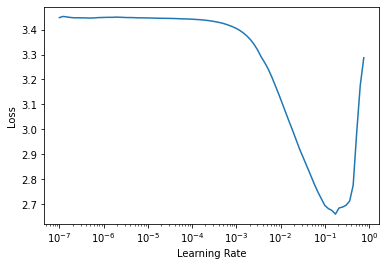

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.145148,2.790671,0.248291,00:00
1,2.206758,1.774574,0.412598,00:00
2,1.698992,1.543758,0.437093,00:00
3,1.435211,1.323819,0.548665,00:00
4,1.216033,1.176522,0.593343,00:00
5,1.048560,1.088907,0.631266,00:00
6,0.929929,1.027773,0.657227,00:00
7,0.813910,0.961912,0.679281,00:00
8,0.728436,0.890570,0.718018,00:00
9,0.649296,0.837760,0.742106,00:00


In [26]:
# stack RNN
from torch.autograd import Variable
from torch.nn import Module
from torch.functional import F


class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel6, self).__init__()
        self.n_hidden = n_hidden
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.rnn = torch.nn.RNN(n_hidden, n_hidden, 2, nonlinearity='relu', batch_first=True)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(2, 64, n_hidden)
    def forward(self, x):
        input = self.i_h(x)
        outs, hs = self.rnn(input, self.h)
        self.h = hs.detach()
        return self.h_o(outs)
    
    def reset(self): self.h = torch.zeros(2, 64, self.n_hidden)


model6 = LMModel6(vocab_sz=len(vocabs), n_hidden=64)
model6.reset()
o6 = model6(X); print(o6.shape)

torch.Size([64, 16, 30])


In [27]:
learn = Learner(dls, model6, loss_func=loss_function, metrics=accuracy, cbs=[ModelResetter])

In [29]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.233351,0.506157,0.859212,00:00
1,0.269089,0.635627,0.795817,00:00
2,0.273084,0.499939,0.856283,00:00
3,0.322807,0.475301,0.866943,00:00
4,0.266825,0.452330,0.876709,00:00
5,0.220879,0.509061,0.852946,00:00
6,0.226294,0.463720,0.869710,00:00
7,0.173541,0.377519,0.907308,00:00
8,0.139935,0.359651,0.916097,00:00
9,0.120585,0.349992,0.919434,00:00
